<a href="https://colab.research.google.com/github/Thewhey-Brian/qbio577_fall2022/blob/main/2022_seq_to_profile_cnn_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Data from a mysterious celltype

Your collaborators performed ChIP-seq for two different factors in a mysterious new cell type.

They send you a file with DNA sequences and the matched profiles for a set of regions.

They believe there is an interaction between the two factors, but would like your help modeling and analyzing the data. 

Try to answer their questions concisely.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import io
import h5py
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

In [ ]:
def download_h5(dataset_url, filename = 'dataset.h5'):
  with requests.Session() as session:
      r = session.get(dataset_url, stream=True)
      r.raise_for_status()
      with open(filename, 'wb') as hd5:
          for chunk in r.iter_content(chunk_size=io.DEFAULT_BUFFER_SIZE):
              hd5.write(chunk)

In [ ]:
DATA_URL = 'https://raw.githubusercontent.com/Fudenberg-Research-Group/2022_seq-to-profile/main/dataset1.h5'

download_h5(DATA_URL, filename = 'dataset1.h5')

In [ ]:
### reading in the h5 data 
with  h5py.File('dataset1.h5', 'r') as h:
    sequences = h['seqs'].asstr()[()]
    targets = h['targets'][()]

Text(0.5, 0, 'position, bp')

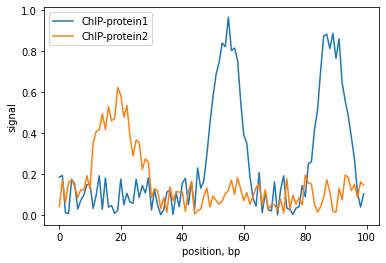

In [ ]:
## To take a quick look at one of their profiles
plt.plot( targets[0,:,0], label='ChIP-protein1');

plt.plot( targets[0,:,1], label='ChIP-protein2');
plt.legend()
plt.ylabel("signal")
plt.xlabel("position, bp")

## 1.0 Try to fit the data with a seq-to-profile neural network. 
- Follow similar steps to those taken in the [Zou et al primer](https://colab.research.google.com/drive/17E4h5aAOioh5DiTo7MZg4hpL6Z_0FyWr#scrollTo=qSOUwoG_vHRA), e.g.: 
  - one-hot encode the DNA, 
  - set aside a test set, 
  - define a convolutional architecture, perhaps with additional or modified layers
  - consider what sort of loss function and activation to use. 
- Use [EarlyStopping](https://keras.io/api/callbacks/early_stopping/)
- Report your test set accuracy. Report an interpretable metric as well. 
- Where does the model do well or struggle? 


Note: if the validation loss is not decreasing during training, the specified model may not be well-matched for the problem at hand. Consider how to modify the model (e.g. a model with sigmoid activation at the final layer would never be able to learn negative values).

In [ ]:
len(sequences)

5000

In [ ]:
sequences

array(['CGATGTGTCCTCAAGTACCATCGGCGCCTTGACCTCCCCCCTGCCACACCTGGGGCGGGCACGAGATGTTTACCGTCAAAACGGCGGGGAGGGAGTGGGT',
       'TTTGCAGGGTTTGTCTGGGCAGTAGTGGTAGTTTCAGTGCCTCTCTACCCTCCCCCATCTAAATAGACTCTGATGACAGTAGGCTGAACTCGAAAGATAT',
       'CTGGGAGGGCCGAACCTGGTTGCAGGGATCCCCTCCCCTTCTAACCATCACACTCTCTCGGGGCAAGAGACGCGTCCCTCCCTTATCCCCTCCCCCGGCT',
       ...,
       'GGCCAAGCGGGTCCCCACCCCATTGGCAAGTTCGACTTTCGTGTCACGGTCTTGTTGGACGGATGGAGGTGCCTGATGTCTTGTGCTCGCCCCGTTACCG',
       'TAATTACTGACAAACAATCAATCACCGATGTAGTAAGCCTTGACGGCCCTCCCCTGACACTTAGGGGCGGGTGTTCTCCGCCCTCCCCTACCCTCCCCAC',
       'CGAAGCCATAGGGATGGCATGACACTCGCCCCCACTGTCCCCTCCCTATCATCTGAGGGGAGAGCACTCGTAGGGAGAGTCCAGGGTGTTATTGTAAGAC'],
      dtype=object)

In [ ]:
# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CGATGTGTCC ... GGGAGTGGGT
One hot encoding of Sequence #1:
 [[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
targets

array([[[0.18693397, 0.04285306],
        [0.19509646, 0.17233472],
        [0.01371456, 0.06440441],
        ...,
        [0.11131296, 0.08826273],
        [0.04060131, 0.1638418 ],
        [0.10595823, 0.14774395]],

       [[0.00731803, 0.19034147],
        [0.19768315, 0.01729043],
        [0.03495773, 0.13858244],
        ...,
        [0.06991564, 0.03575747],
        [0.19402792, 0.01899964],
        [0.12425554, 0.03564619]],

       [[0.8409291 , 0.03339849],
        [0.77489094, 0.12247718],
        [0.84373463, 0.13402167],
        ...,
        [0.29823266, 0.13811015],
        [0.32180015, 0.00746408],
        [0.17854939, 0.17040232]],

       ...,

       [[0.15042477, 0.17073063],
        [0.03019776, 0.05743501],
        [0.17464405, 0.18799943],
        ...,
        [0.19679073, 0.01991717],
        [0.15840526, 0.04667264],
        [0.1022204 , 0.04779275]],

       [[0.08642412, 0.11934765],
        [0.18346027, 0.08687415],
        [0.04566572, 0.0697746 ],
        .

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, targets, test_size=0.25, random_state=42)

In [ ]:
train_features.shape

(3750, 100, 4)

In [ ]:
train_labels.shape

(3750, 100, 2)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(train_features.shape[1], 4)))
model.add(MaxPooling1D(pool_size=4, padding="same"))
model.add(Flatten())
model.add(Dense(300, activation='relu'))
#model.add(Dense(100, activation='relu'))
model.add(Dense(200))
model.add(Reshape((100, 2)))
model.compile(loss='mse', optimizer="adam")
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 89, 32)            1568      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 23, 32)           0         
 1D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 736)               0         
                                                                 
 dense_15 (Dense)            (None, 300)               221100    
                                                                 
 dense_16 (Dense)            (None, 200)               60200     
                                                                 
 reshape_3 (Reshape)         (None, 100, 2)            0         
                                                      

In [ ]:
train_labels[0].shape

(100, 2)

In [ ]:
callback = EarlyStopping(monitor='loss', patience=3)

In [ ]:
history = model.fit(train_features, train_labels, epochs=100, verbose=0, validation_split=0.25)#callbacks=[callback]
#history = model.fit(train_features, train_labels, epochs=50, verbose=0)

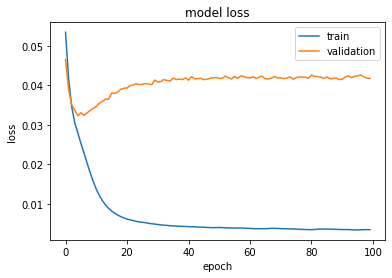

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
test1=model.predict(test_features)

40/40 [==============================] - 0s 2ms/step


In [ ]:
def plot_result(x, y):
  #plt.scatter(train_features, train_labels, label='Data')
  plt.scatter(x, y, color='k')
  plt.xlabel('predicted')
  plt.ylabel('truth')
  plt.legend()

## 1.1 Can you determine any rule(s) that influence the profiles for the two factors?
Try saliency mapping as employed in the primer. Are there motifs, or an interplay between motifs, that boost or dampen the profiles? 

In [ ]:
def compute_salient_bases(model, x):
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  
  x_value = np.expand_dims(x, axis=0)
  gradients = compute_gradients([x_value])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
  return sal

In [ ]:
sequence_index = 1999  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C1') for i in range(5,17)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the positive sequences'
          ' (green indicates the actual bases in motif)');

TypeError: ignored

#Part 2: More data from another mysterious cell type

Your collaborators send you an update: they performed ChIP-seq for the same two factors in a yet another mysterious cell type and are getting puzzling results. They send you a second file. Seems like they are pretty good collaborators!

In [ ]:
DATA_URL2 = 'https://raw.githubusercontent.com/Fudenberg-Research-Group/2022_seq-to-profile/main/dataset2.h5'


## 2.0 Does your model trained on the original data predict this data well or poorly? 

## 2.1 Does a model re-trained on this new dataset reach the same level of predictive ability?

## 2.2 Can you determine different rule(s) for the influence on the profiles in this new cell type?